SIGNATURE VERIFICATION 

Import Libraries

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
from imblearn.over_sampling import SMOTE
import joblib

Load Genuine and Forged Image Path

In [2]:
gen = [glob.glob('C:/Project/Signature Verification/archive\Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
       glob.glob('C:/Project/Signature Verification/archive\Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
       glob.glob('C:/Project/Signature Verification/archive\Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
       glob.glob('C:/Project/Signature Verification/archive\Dataset_Signature_Final/Dataset/dataset4/real/*.*')]

forg = [glob.glob('C:/Project/Signature Verification/archive/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
        glob.glob('C:/Project/Signature Verification/archive/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
        glob.glob('C:/Project/Signature Verification/archive/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
        glob.glob('C:/Project/Signature Verification/archive/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')]

In [3]:
gen_images = [img for sublist in gen for img in sublist]
forg_images = [img for sublist in forg for img in sublist]

In [4]:
print(f"Total genuine signatures: {len(gen_images)}")
print(f"Total forged signatures: {len(forg_images)}")

Total genuine signatures: 270
Total forged signatures: 360


Preprocessing 

In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (220, 155))  # Resize to standard size
    return img

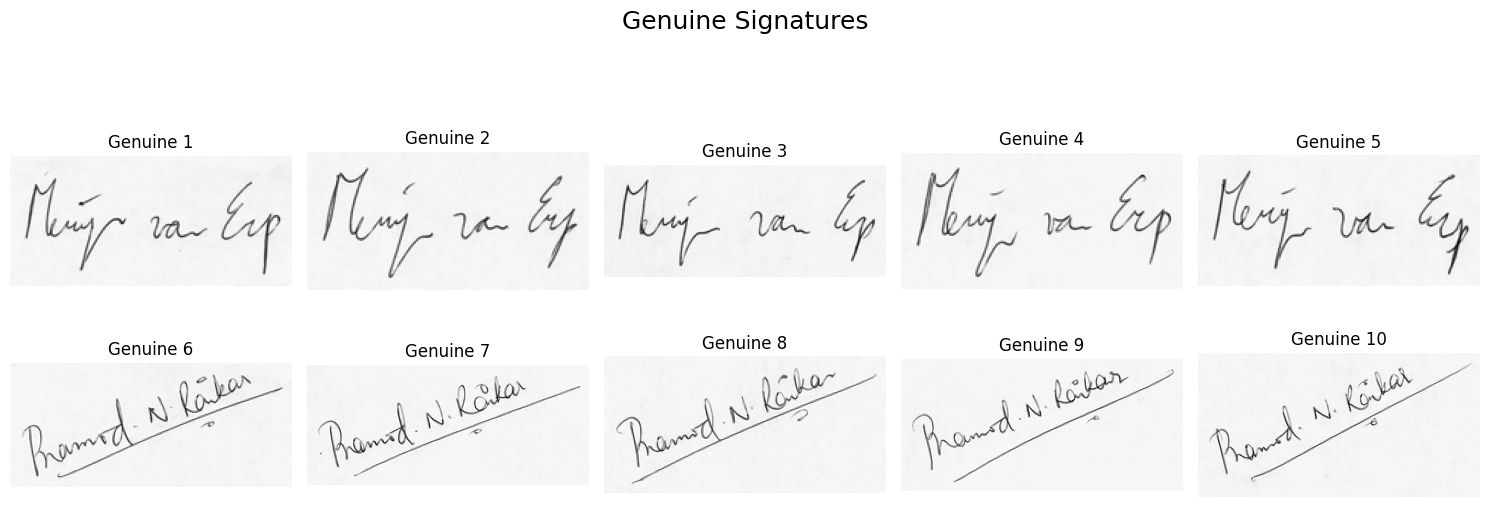

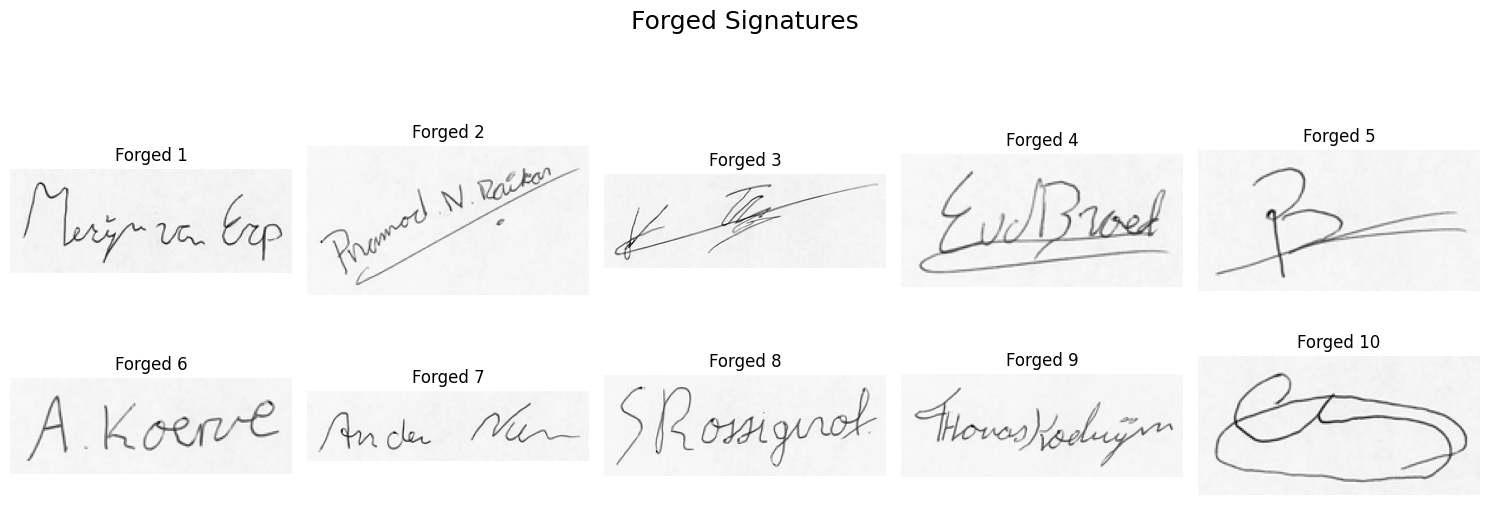

In [6]:
# ## 🔍 Display Multiple Genuine and Forged Signature Images in Grid

def display_images_grid(images, title, max_images=30, cols=6):
    rows = (min(len(images), max_images) + cols - 1) // cols
    plt.figure(figsize=(3 * cols, 3 * rows))
    for i in range(min(len(images), max_images)):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.suptitle(f"{title} Signatures", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display genuine signatures
display_images_grid(gen_images, "Genuine", max_images=10, cols=5)

# Display forged signatures
display_images_grid(forg_images, "Forged", max_images=10, cols=5)


HOG Feature Extraction

In [7]:
def extract_features(images):
    feature_list = []
    for img_path in images:
        img = preprocess_image(img_path)
        features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
        feature_list.append(features)
    return feature_list

In [8]:
gen_features = extract_features(gen_images)
forg_features = extract_features(forg_images)

Labeling the data: Genuine = 0, Forged = 1

In [9]:
X = np.array(gen_features + forg_features)
y = np.array([0]*len(gen_features) + [1]*len(forg_features))

Balance Dataset using SMOTE

In [10]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print(f"✅ After SMOTE - Samples: {len(X_res)}, Genuine: {sum(y_res == 0)}, Forged: {sum(y_res == 1)}")

✅ After SMOTE - Samples: 720, Genuine: 360, Forged: 360


Split data into training and testing sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


Train the model using SVM

In [12]:
model = SVC(kernel='linear')  
model.fit(X_train, y_train)

SVC(kernel='linear')

Save the model to a .pkl file

In [13]:
joblib.dump(model, 'signature_model.pkl')
print("✅ Model saved as 'signature_model.pkl'")

✅ Model saved as 'signature_model.pkl'


Predict And Evaluate

In [14]:
y_pred = model.predict(X_test)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9236111111111112

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.93        76
           1       0.89      0.96      0.92        68

    accuracy                           0.92       144
   macro avg       0.92      0.93      0.92       144
weighted avg       0.93      0.92      0.92       144



Confusion matrix

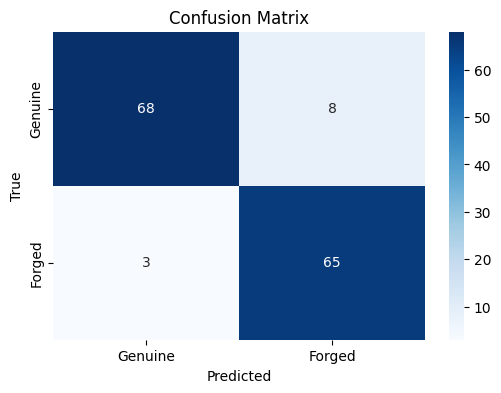

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Genuine", "Forged"], yticklabels=["Genuine", "Forged"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()